# **LoRaWAN data analysis**

### Zagaria Simone Student ID: 2145389
### Alessio Lani Student ID: 1857003  

### **Smart Environments aa 2024/2025**

# **1. Introduction**

The aim of our project is to make a deep and meaningful analysis on
the LoRaWAN packets collected by our gateway located in Sapienza. \\

We chose this project because we want to understand how devices behave within a smart environment network, what kinds of packets are collected by our gateway, and how
these devices interact with the network.

## **Importing Libraries**

Importing the libraries needed for the project

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import base64
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
import plotly.express as px
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# **2. Preprocessing**

Before diving into the analysis, we needed to preprocess the data to ensure its quality and consistency. This process involved handling missing values, selecting only the columns pertinent to the analyses and converting columns into a readable format.

We decided to import and preprocess both the datasets at the same time since they share most of the columns, and, as such, most of the preprocessing pipeline.

In [ ]:
# Let's first import the datasets

df_uplink = pd.read_csv('upPackets.csv', sep=';')

df_downlink = pd.read_csv('downPackets.csv', sep=';')

df_uplink.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,datr,codr,rssi,lsnr,size,data
0,5050033,AC1F09FFFE057698,Nan,Nan,1745724660,868.5,2,1,1,LORA,SF7BW125,45781,-109,-3.8,23,AL4dGPMV4YAAhd8CAQBA7sDxj8Md3U8=
1,5050034,AC1F09FFFE057698,Nan,Nan,1745724661,867.9,7,0,1,LORA,SF7BW125,45781,-119,-5.8,60,QD5gRwGA6AAKL1WrqG3ETk7yypp81J64WN9dg1okP0jXr1...
2,5050035,AC1F09FFFE057698,Nan,Nan,1745724662,868.3,1,1,1,LORA,SF7BW125,45781,-105,-5.8,9,C8bTDAVZAv4B
3,5050036,AC1F09FFFE057698,Nan,Nan,1745724665,867.1,3,0,1,LORA,SF7BW125,45781,-121,-4.0,60,QHqxywCA2wAKRkyI6R2oWQc3XriND3yUxSKQXHVn1mObEt...
4,5050037,AC1F09FFFE057698,Nan,Nan,1745724668,868.3,1,1,1,LORA,SF8BW125,45781,-108,-3.3,23,AL4dGPMV4YAAhd8CAQBA7sDr5TKBe4Q=


## **Formatting and Feature Selection**

Let's get some basic info on the dataset:

In [ ]:
df_uplink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141161 entries, 0 to 141160
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      141161 non-null  int64  
 1   gwui    141161 non-null  object 
 2   time    141161 non-null  object 
 3   tmms    141161 non-null  object 
 4   tmst    141161 non-null  int64  
 5   freq    141161 non-null  float64
 6   chan    141161 non-null  int64  
 7   rfch    141161 non-null  int64  
 8   stat    141161 non-null  int64  
 9   modu    141161 non-null  object 
 10  datr    141161 non-null  object 
 11  codr    141161 non-null  int64  
 12  rssi    141161 non-null  int64  
 13  lsnr    141161 non-null  float64
 14  size    141161 non-null  int64  
 15  data    141161 non-null  object 
dtypes: float64(2), int64(8), object(6)
memory usage: 17.2+ MB


In [ ]:
df_downlink.info()

We observe we have 15 fields in both of the datasets. We drop directly the fields that won't be needed for our analyses or that are filled with "Nan" values:

In [ ]:
df_uplink = df_uplink.drop(columns=['time', 'tmms', 'chan', 'rfch', 'stat', 'codr'])

df_downlink = df_downlink.drop(columns=['imme', 'tmms', 'rfch', 'rfch', 'fdev', 'prea'])

Next, we format the Timestamps into a readable format, since we know they are counted as Unix Epochs:

In [ ]:

df_uplink['timestamp'] = pd.to_datetime(df_uplink['tmst'], unit='s')

df_downlink['timestamp'] = pd.to_datetime(df_downlink['tmst'], unit='s')


next, we preprocess and format also the 'datr' field, which is formatted as a string and contains the Spreading Factor (SF) and the Bandwidth (BW) of each message:

In [ ]:

datr_counts_uplink = df_uplink['datr'].value_counts().sort_index()
datr_counts_downlink = df_downlink['datr'].value_counts().sort_index()

# Extracting spreading factor (SF) and bandwidth (BW) from 'datr'
df_uplink['SF'] = df_uplink['datr'].str.extract(r'SF(\d+)')
df_uplink['BW'] = df_uplink['datr'].str.extract(r'BW(\d+)')

df_downlink['SF'] = df_downlink['datr'].str.extract(r'SF(\d+)')
df_downlink['BW'] = df_downlink['datr'].str.extract(r'BW(\d+)')


## **Decoding Packets**

Next, we decode the packets using a base 64 packet decoder to uncover the metadata regarding the fields of the data received:

In [ ]:

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None


Let's apply this to decode the data field and substitute the new fields to the 'Data' field in the dataset:

In [ ]:
decoded_data_uplink = df_uplink['data'].apply(decode_lorawan_packet)
decoded_data_downlink = df_downlink['data'].apply(decode_lorawan_packet)

# Visualization of decoded data fields
pprint(decoded_data_uplink.head().tolist())

decoded_df_uplink = decoded_data_uplink.apply(pd.Series)
df_uplink = pd.concat([df_uplink, decoded_df_uplink], axis=1)

decoded_df_downlink = decoded_data_downlink.apply(pd.Series)
df_downlink = pd.concat([df_downlink, decoded_df_downlink], axis=1)



[{'DevAddr': 'f3181dbe',
  'FCnt': 32993,
  'FCtrl': 21,
  'FOpts': '0085df0201',
  'FPort': 0,
  'FRMPayload': '40eec0f18fc31ddd4f',
  'MHDR': 0,
  'MType': 0,
  'Major': 0,
  'RFU': 0},
 {'DevAddr': '0147603e',
  'FCnt': 232,
  'FCtrl': 128,
  'FOpts': None,
  'FPort': 10,
  'FRMPayload': '2f55aba86dc44e4ef2ca9a7cd49eb858df5d835a243f48d7af507d242198e19a2a5173fbb563804d5146248f52356f6743854a',
  'MHDR': 64,
  'MType': 2,
  'Major': 0,
  'RFU': 0},
 {'DevAddr': '050cd3c6',
  'FCnt': 65026,
  'FCtrl': 89,
  'FOpts': '01',
  'FPort': None,
  'FRMPayload': None,
  'MHDR': 11,
  'MType': 0,
  'Major': 3,
  'RFU': 2},
 {'DevAddr': '00cbb17a',
  'FCnt': 219,
  'FCtrl': 128,
  'FOpts': None,
  'FPort': 10,
  'FRMPayload': '464c88e91da85907375eb88d0f7c94c522905c7567d6639b12dc09cca243dc67e6b16e1a997282e5900ed70e5d0e2a78f45d62',
  'MHDR': 64,
  'MType': 2,
  'Major': 0,
  'RFU': 0},
 {'DevAddr': 'f3181dbe',
  'FCnt': 32993,
  'FCtrl': 21,
  'FOpts': '0085df0201',
  'FPort': 0,
  'FRMPayload': '4

In [ ]:
# Dropping cleaned columns and saving the preprocessed dataset
df_uplink = df_uplink.drop(columns=['datr', 'data', 'tmst'])
df_downlink = df_downlink.drop(columns=['datr', 'data', 'tmst'])


df_uplink.to_csv('cleaned_lorawan_data_FULL.csv', index=False)
df_downlink.to_csv('cleaned_downlink_data.csv', index=False)


We directly use the cleaned file for importing the dataframe for efficiency

In [19]:
df_uplink_cleaned = pd.read_csv('cleaned_lorawan_data_FULL.csv')

df_downlink_cleaned = pd.read_csv('cleaned_downlink_data.csv')

# **3. Uplink Analyses**

Let's first have a look at the uplink dataset. We notice immediately that it's way larger compared to the downlink dataset, counting more than 5 milion rows and having 19 columns, and the data ranges from October 2024 to May 2025:

In [20]:
df_uplink_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5895982 entries, 0 to 5895981
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   gwui        object 
 2   freq        float64
 3   modu        object 
 4   rssi        int64  
 5   lsnr        float64
 6   size        int64  
 7   timestamp   object 
 8   SF          int64  
 9   BW          int64  
 10  MHDR        float64
 11  MType       float64
 12  RFU         float64
 13  Major       float64
 14  DevAddr     object 
 15  FCtrl       float64
 16  FCnt        float64
 17  FOpts       object 
 18  FPort       float64
 19  FRMPayload  object 
dtypes: float64(9), int64(5), object(6)
memory usage: 899.7+ MB


In [21]:
# Get the range of timestamps
start_date = df_uplink_cleaned['timestamp'].min()
end_date = df_uplink_cleaned['timestamp'].max()

start_date, end_date

('2024-10-17 18:06:47', '2025-05-15 15:03:25')

When inspacting the cleaned dataset, we immediately noticed that many of the payloads were missing. This suggested that the packets, although received on LoRa frequencies, were not actual LoRa transmissions. These so-called "garbage packets", as shown in the graph below, account for a significant portion of the dataset, reaching up to $52\%$ of the messages collected in our case.

In [22]:
# Counting number of payloads
payload_counts = df_uplink_cleaned['FRMPayload'].apply(lambda x: 'Present' if pd.notnull(x) else 'None').value_counts().reset_index()
payload_counts.columns = ['PayloadStatus', 'Count']

color_map = {'Present': '#8fd9b6', 'None': '#f08080'}
palette = [color_map[status] for status in payload_counts['PayloadStatus']]

# Plotting pie graph
fig = px.pie(
    payload_counts,
    values='Count',
    names='PayloadStatus',
    title='Percentage of Packages with Payload',
    color_discrete_sequence=palette
)

fig.update_layout(width=800, height=600)
fig.show()


This may indicate the presence of numerous devices near the gateway that are transmitting on similar frequencies, effectively polluting or cluttering the dataset. Such a scenario is plausible, especially considering that the gateway is located in a densely populated area within a highly urbanized city.

Next, we want to assess how many unique devices were responsible for sending these messages, in order to better quantify their impact on the dataset.

In [23]:
# Filtering the dataset and creating copies of dataset with and without payload
devices_with_payload = df_uplink_cleaned[df_uplink_cleaned['FRMPayload'].notnull()]
devices_without_payload = df_uplink_cleaned[df_uplink_cleaned['FRMPayload'].isnull()]

# Also creating sets of the devaddresses of these devices for indentifying unique devices
devices_with_payload_set = set(devices_with_payload['DevAddr'])
devices_without_payload_set = set(devices_without_payload['DevAddr'])
devices_with_both_set = devices_with_payload_set.intersection(devices_without_payload_set)


In [24]:

# Number of devices transmitting ONLY packets with payload
only_with_payload = devices_with_payload_set - devices_with_both_set

# Number of devices transmitting ONLY packets without payload
only_without_payload = devices_without_payload_set - devices_with_both_set

# Counts
print(f"Devices with only payload: {len(only_with_payload)}")
print(f"Devices with only no-payload: {len(only_without_payload)}")
print(f"Devices with mixed traffic: {len(devices_with_both_set)}")

# Total unique devices
total_unique_devices = len(devices_with_payload_set.union(devices_without_payload_set))
print(f"Total unique devices: {total_unique_devices}")



Devices with only payload: 150550
Devices with only no-payload: 16333
Devices with mixed traffic: 101
Total unique devices: 166984


In [25]:
# Prepare data
labels = ['Only Payload', 'Only No-Payload', 'Both']
counts = [len(only_with_payload), len(only_without_payload), len(devices_with_both_set)]
device_type_df = pd.DataFrame({'DeviceType': labels, 'Count': counts})

color_map = {
    'Only Payload': '#8fd9b6',
    'Only No-Payload': '#f08080',
    'Both': "#e9c866"
}
palette = [color_map[label] for label in device_type_df['DeviceType']]

# Plotting pie chart
fig = px.pie(
    device_type_df,
    values='Count',
    names='DeviceType',
    title='Percentage of Devices by Payload Transmission Type',
    color_discrete_sequence=palette
)

fig.update_layout(width=800, height=600)
fig.show()

The analysis revealed that the number of devices sending only garbage packets was significantly lower than the number of actual LoRa devices. However, these devices appeared to transmit at a much higher rate, meaning that, despite being fewer, they contribute disproportionately to the overall noise in the data. In particular, they represent only the $8\%$ of the total devices.

This suggests that, if their number were to grow, they could pose a greater issue than initially expected.

## **FPort Analysis**

Next, we also measured the distribution of the FPort:

In [26]:
# Group small categories manually
def categorize_fport(fport):
    if pd.isnull(fport):
        return 'None'
    elif fport == 0:
        return '0 (Control)'
    elif 1 <= fport <= 223:
        return '1–223 (Application)'
    else:
        return '224+ (Reserved)'

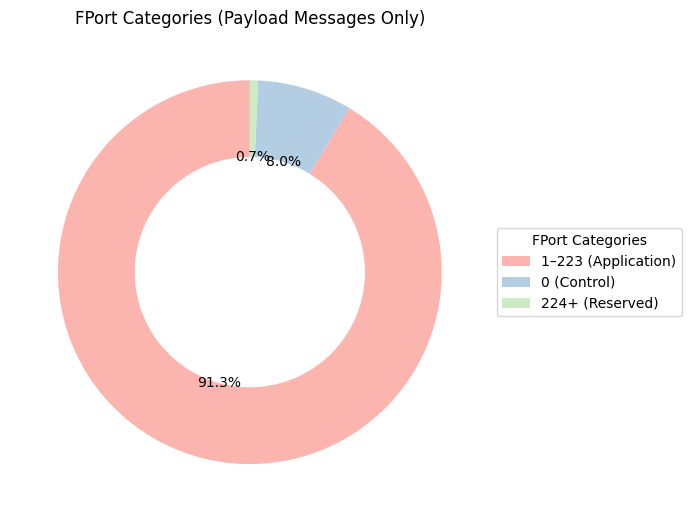

In [27]:

# Apply to payload messages only
payload_df = devices_with_payload.copy()
payload_df['FPortCategory'] = payload_df['FPort'].apply(categorize_fport)

# Count by category
fport_cat_counts = payload_df['FPortCategory'].value_counts()

# Plot donut chart with legend
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    fport_cat_counts,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.4),  # donut style
    textprops=dict(color="black"),
    colors=plt.cm.Pastel1.colors
)

# Add legend outside the chart
plt.legend(wedges, [f"{label}" for label, count in zip(fport_cat_counts.index, fport_cat_counts)],
           title="FPort Categories", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('FPort Categories (Payload Messages Only)')
plt.tight_layout()
plt.show()


Most of the messages are application
messages, with only $8\%$ being control
messages.

## **Frequency and Spreading Factor Analyses**

Next, we made various analyses focusing on the packets that contained a payload. The minimum and maximum transmission frequencies observed among the payload packets fell within the expected range for LoRa communication—typically between 863 MHz and 870 MHz.

In [28]:

# Calculate min and max frequency
min_freq_p = devices_with_payload['freq'].min()
max_freq_p = devices_with_payload['freq'].max()

print(min_freq_p, max_freq_p)

min_freq_np = devices_without_payload['freq'].min()
max_freq_np = devices_without_payload['freq'].max()

print(min_freq_np, max_freq_np)


867.1 868.5
867.1 868.5


Interestingly, the garbage packets were also transmitted within this frequency range, which likely explains why they were captured by the gateway despite not being valid LoRa packets.

We then examined the distribution of the Spreading Factor (SF), RSSI, and LSNR per message, as these indicators can provide useful insights into the quality of the received transmissions.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When gr

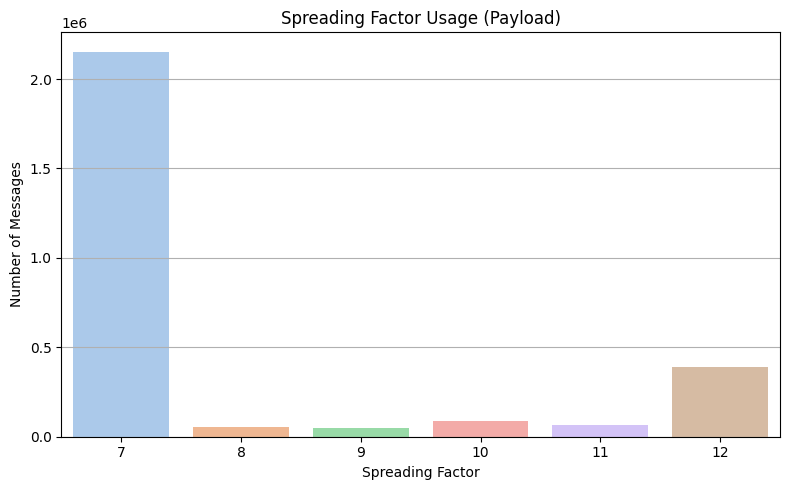

In [29]:
# Counting SF values to plot the distribution
sf_counts = devices_with_payload['SF'].value_counts().sort_index().reset_index()
sf_counts.columns = ['SF', 'Count']

# Plotting distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=sf_counts, x='SF', y='Count', hue='SF', palette='pastel', legend=False)
plt.title('Spreading Factor Usage (Payload)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Messages')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When gr

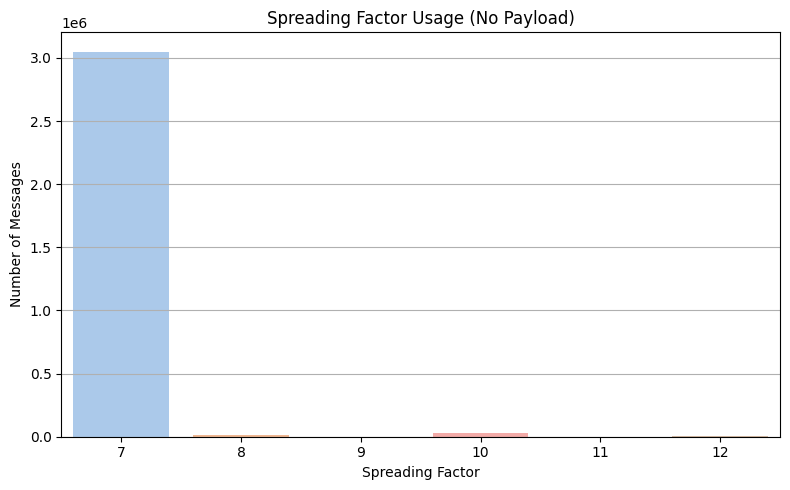

In [30]:

sf_counts = devices_without_payload['SF'].value_counts().sort_index().reset_index()
sf_counts.columns = ['SF', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=sf_counts, x='SF', y='Count', hue='SF', palette='pastel', legend=False)
plt.title('Spreading Factor Usage (No Payload)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Messages')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The chart clearly shows that Spreading Factor 7 (SF7) is used in the vast majority of transmissions, while higher values—such as SF8 through SF12—appear only rarely. This pattern suggests that most devices are communicating over short distances and maintain a strong, stable connection with the gateway. Interestingly, a similar distribution is observed among the garbage packets, and further accentuates the already unbalanced trend, with virtually all transmissions using SF7, and higher SF values being almost entirely absent.
This suggests that these transmissions also originate from areas with good signal conditions, likely close to the gateway.

As for the bandwidth, it’s always set to 125 kHz, which is the default and most commonly used setting in LoRaWAN networks.


RSSI (Received Signal Strength Indicator) measures the strength of the signal received by the gateway or end device. In LoRa communications, RSSI values typically range from -30 dBm (indicating a very strong signal) to -120 dBm (indicating a very weak signal).

Min RSSI: -142, Max RSSI: -42


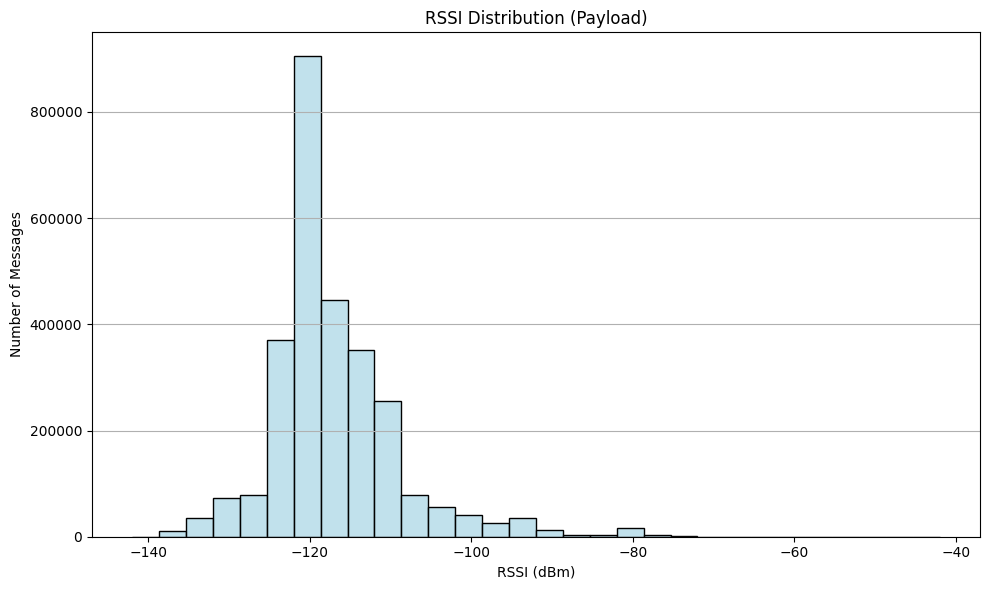

In [31]:
# min and max RSSI
min_rssi = devices_with_payload['rssi'].min()
max_rssi = devices_with_payload['rssi'].max()

print(f"Min RSSI: {min_rssi}, Max RSSI: {max_rssi}")

# Plot RSSI distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=devices_with_payload, x='rssi', bins=30, kde=False, color='lightblue', edgecolor='black')
plt.title('RSSI Distribution (Payload)')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Number of Messages')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Min RSSI: -136, Max RSSI: -69


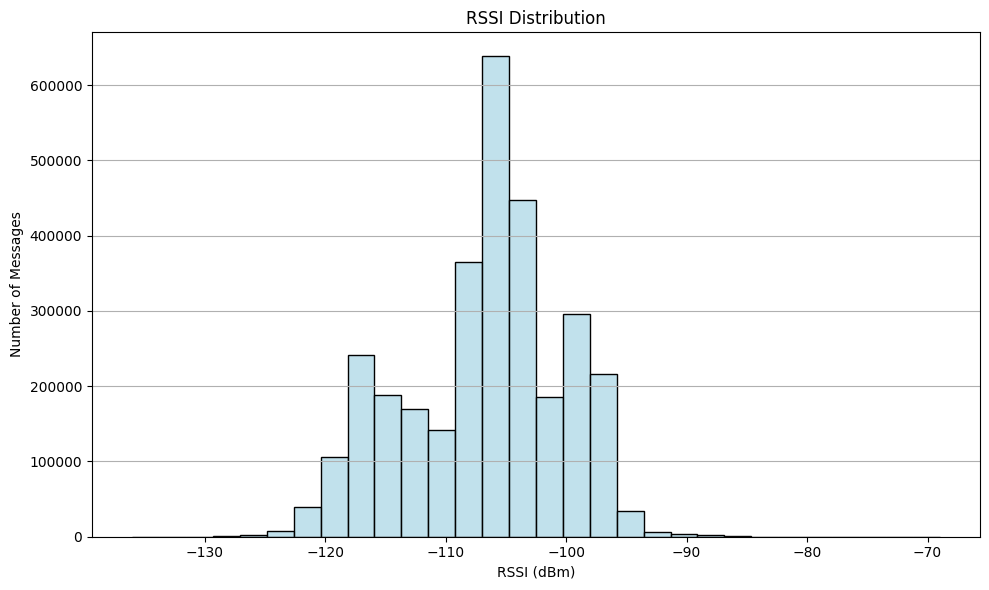

In [32]:
# min and max RSSI
min_rssi_np = devices_without_payload['rssi'].min()
max_rssi_np = devices_without_payload['rssi'].max()

print(f"Min RSSI: {min_rssi_np}, Max RSSI: {max_rssi_np}")

# Plot RSSI distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=devices_without_payload, x='rssi', bins=30, kde=False, color='lightblue', edgecolor='black')
plt.title('RSSI Distribution')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Number of Messages')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In our case, most RSSI values for payload messages are clustered between -125 dBm and -110 dBm, which suggests a relatively weak—if not borderline poor—signal strength. This could be due to the distance between the devices and the gateway, or the presence of significant interference and physical obstacles. The latter explanation is more likely, considering the gateway is located in a densely populated and highly urbanized area.

In contrast, garbage packets tend to show stronger RSSI values, with their distribution concentrated between -110 dBm and -100 dBm. This indicates that these transmissions likely originate from devices much closer to the gateway, further reinforcing the hypothesis that they are not typical LoRa nodes but potentially nearby sources of interference.

## **3D graph for SF RSSI & number of messages**

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\800570586.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\800570586.py:64: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



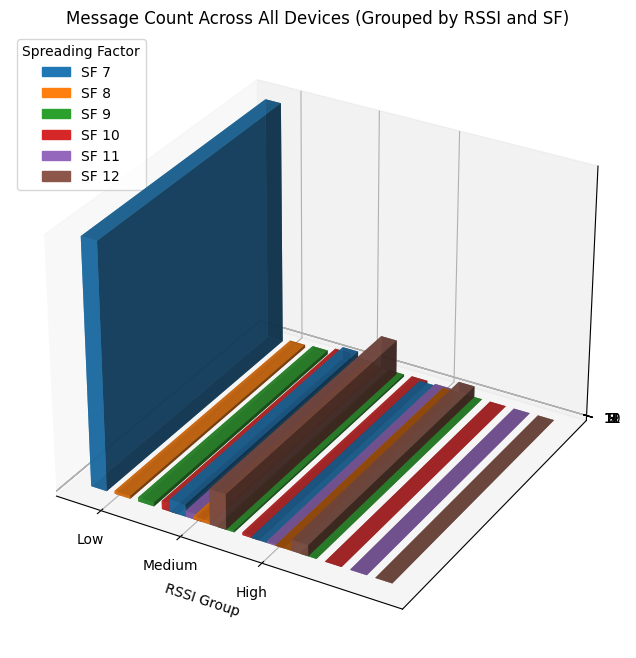

In [33]:
# Make sure the fields are numeric
payload_df['rssi'] = pd.to_numeric(payload_df['rssi'], errors='coerce')
payload_df['SF'] = pd.to_numeric(payload_df['SF'], errors='coerce')

# Remove incomplete rows
df_clean = payload_df.dropna(subset=['DevAddr', 'rssi', 'SF'])

# Define bins for RSSI
rssi_bins = pd.cut(df_clean['rssi'], bins=3, labels=['Low', 'Medium', 'High'])

# Add the categories to the DataFrame
df_clean['rssi_group'] = rssi_bins

# Group data by RSSI category and SF to count occurrences
grouped_df = df_clean.groupby(['rssi_group', 'SF']).size().reset_index(name='count')

# Discrete color palette for SF
sf_levels = sorted(grouped_df['SF'].dropna().unique())
color_palette = plt.get_cmap('tab10')
sf_color_map = {sf: color_palette(i % 10) for i, sf in enumerate(sf_levels)}
grouped_df['color'] = grouped_df['SF'].map(sf_color_map)

# 3D bar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare bar positions
x_labels = grouped_df['rssi_group'].unique()
z_levels = sf_levels

x_pos = np.arange(len(x_labels))
y_pos = np.zeros(len(grouped_df))  # Only one "level" for the missing dimension

# Create bars
for i, sf in enumerate(z_levels):
    sf_data = grouped_df[grouped_df['SF'] == sf]
    for j, rssi_group in enumerate(x_labels):
        count = sf_data[sf_data['rssi_group'] == rssi_group]['count'].values
        if count.size > 0:
            ax.bar3d(j + i * 0.3 - 0.3, y_pos[sf_data[sf_data['rssi_group'] == rssi_group].index[0]], sf - 0.25, 0.2, 0.8, count[0],
                     color=sf_color_map[sf], alpha=0.8)

# Axis labels
ax.set_xlabel('RSSI Group')
ax.set_ylabel('')  # No second dimension
ax.set_zlabel('Spreading Factor (SF)')
ax.set_title('Message Count Across All Devices (Grouped by RSSI and SF)')

# Set ticks for x-axis
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels)

# Set ticks for z-axis (SF)
ax.set_zticks(z_levels)

# Remove ticks and labels from y-axis
ax.set_yticks([])
ax.set_yticklabels([])

# SF color legend
legend_handles = [mpatches.Patch(color=sf_color_map[sf], label=f'SF {int(sf)}') for sf in sf_levels]
ax.legend(handles=legend_handles, title='Spreading Factor', loc='upper left')

plt.tight_layout()
plt.show()

## **Mobility Classification using GM-RSSI**

To distinguish between mobile and fixed devices in this LoRaWAN network, we analyze the behavior over time of the Received Signal Strength Indicator (RSSI). In fact, in fixed devices, RSSI usually tends to remain relatively stable over time, typically with a standard deviation of less than 2 dB. In contrast, mobile devices—such as those carried by people or mounted on vehicles—introduce more pronounced and irregular fluctuations, often exceeding 3 to 4 dB.

To capture these dynamics more reliably, we based our classification on deviations from the Geometric Mean rather than the arithmetic mean. This choice offers advantages such as being robust to outliers and being compatible with signal propagation.
Based on this, we computed the RSSI-GM score, defined as the average absolute deviation from the geometric mean. Devices with a score exceeding a certain threshold were classified as mobile.

In [35]:
# Group by device
def geometric_mean_rssi(group):
    rssi_values = group['rssi']
    # Convert RSSI to positive values for GM (since RSSI is negative)
    rssi_positive = -rssi_values[rssi_values < 0]
    gm = (np.prod(rssi_positive) ** (1 / len(rssi_positive)))
    return -gm


# Compute RSSI-GM score as average absolute deviation from GM
def compute_rssi_gm_score(group):
    gm = geometric_mean_rssi(group)
    return np.mean(np.abs(group['rssi'] - gm))

# Threshold for mobility
RSSI_GM_THRESHOLD = 4.0

In [36]:
# Compute each metric for both payload and non-payload devices
message_counts = devices_with_payload.groupby('DevAddr')['rssi'].count()
gm_rssi = devices_with_payload.groupby('DevAddr').apply(geometric_mean_rssi)
rssi_gm_scores = devices_with_payload.groupby('DevAddr').apply(compute_rssi_gm_score)

mobility_class = rssi_gm_scores.apply(lambda x: 'Mobile' if x > RSSI_GM_THRESHOLD else 'Fixed')

message_counts_none = devices_without_payload.groupby('DevAddr')['rssi'].count()
gm_rssi_none = devices_without_payload.groupby('DevAddr').apply(geometric_mean_rssi)
rssi_gm_scores_none = devices_without_payload.groupby('DevAddr').apply(compute_rssi_gm_score)

# Classify mobility
mobility_class_none = rssi_gm_scores_none.apply(lambda x: 'Mobile' if x > RSSI_GM_THRESHOLD else 'Fixed')

# Combine into final summary DataFrame
device_payload_summary = pd.DataFrame({
    'DevAddr': message_counts.index,
    'message_count': message_counts.values,
    'geometric_mean_rssi': gm_rssi.values,
    'rssi_gm_score': rssi_gm_scores.values,
    'mobility_class': mobility_class.values
})

device_none_summary = pd.DataFrame({
    'DevAddr': message_counts_none.index,
    'message_count': message_counts_none.values,
    'geometric_mean_rssi': gm_rssi_none.values,
    'rssi_gm_score': rssi_gm_scores_none.values,
    'mobility_class': mobility_class_none.values
})


C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\827420188.py:6: RuntimeWarning:

invalid value encountered in power

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\3660450798.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\827420188.py:6: RuntimeWarning:

invalid value encountered in power

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\3660450798.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the groupin

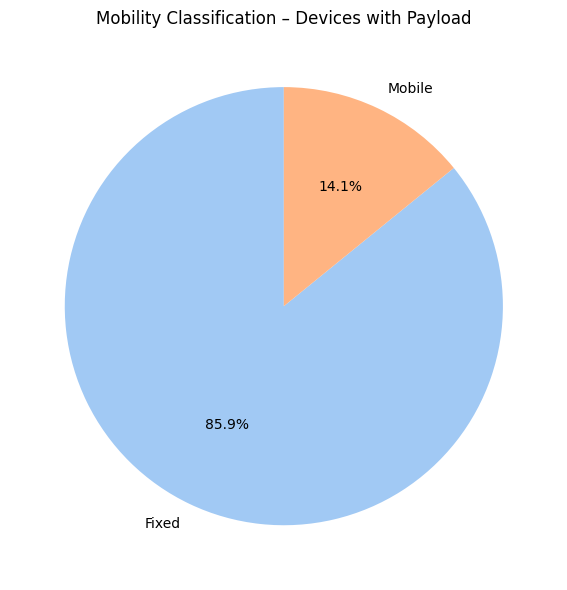

In [37]:
# Count mobility classifications
mobility_counts = device_payload_summary['mobility_class'].value_counts()

# Plot payload graph
plt.figure(figsize=(6, 6))
colors = sns.color_palette("pastel")
plt.pie(
    mobility_counts,
    labels=[f"{label}" for label, count in mobility_counts.items()],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Mobility Classification – Devices with Payload')
plt.ylabel('')
plt.tight_layout()
plt.show()


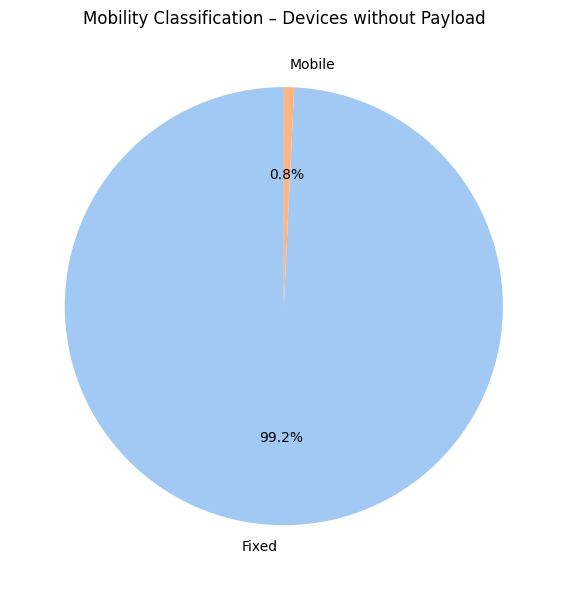

In [38]:
# Count mobility classifications
mobility_counts = device_none_summary['mobility_class'].value_counts()

# Plot non playload graph
plt.figure(figsize=(6, 6))
colors = sns.color_palette("pastel")
plt.pie(
    mobility_counts,
    labels=[f"{label}" for label, count in mobility_counts.items()],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Mobility Classification – Devices without Payload')
plt.ylabel('')
plt.tight_layout()
plt.show()


We observe that almost $15\%$ of the Devices that transmitted payload are estimated to be mobile. This is an interesting result, as it differentiates strongly with the devices that transmitted only garbage packets, which display an extremely skewed trend: nearly all of them are classified as fixed.  \
This results suggests that these devices exhibit very low signal fluctuation over time, likely due to their fixed position near the gateway or consistent transmission conditions.

## **Distance Estimation**

Now, based on this classification, we proceed to estimate the distance of the devices from the gateway. To do so, we applied an RSSI-based distance estimation formula, which relies on signal attenuation characteristics in free-space or urban environments. \
This method provides only a rough approximation due to the influence of environmental factors such as buildings, obstacles, and interference, but it is useful to have a general idea of the patterns of distance within the datasets. 

The used RSSI-based distance estimation formula is:

\begin{equation}
d=10^{\frac{(P-R)}{10n}}
\end{equation}

Where:

- P: RSSI at 1 meter (as a reference value)
- R: measured RSSI from the dataset
- n: path loss exponent, typically from 2 to 4 for LoRaWAN, depending on the environment type


In [39]:
# Parameters used
P = -40  # Reference RSSI at 1 meter (assumed)
n = 3.2  # Higher path loss exponent due to urban interference (typical 2.7–3.5)

# Estimate distance for each message with a valid RSSI
df_uplink_cleaned['estimated_distance'] = 10 ** ((P - df_uplink_cleaned['rssi']) / (10 * n))


For this dataset, we assume a reference value of $P = -40 dBm$, which is common for LoRa at $1$ meter with typical antennas. For $n$, we choose $3.2$, an high path loss due to the higher urban interference, since tipically in higher urbanized area values from $2.7$ to $3.5$ are chosen. Moreover, we again use Geometric Mean for the RSSI due to its properties. This analysis is not meant to gives a relative sense of vicinity, not a precise estimation.

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\2766027158.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



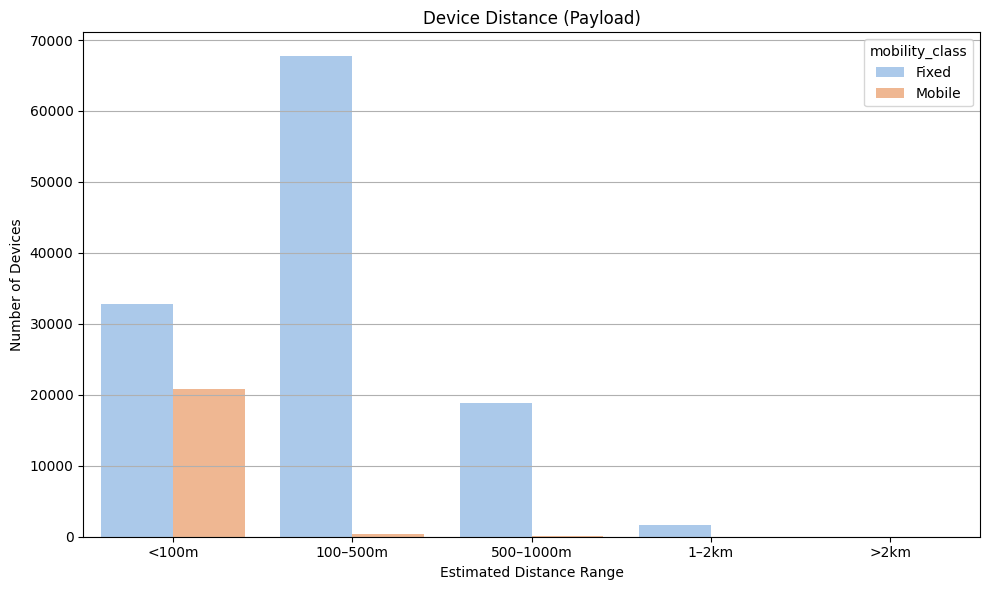

In [40]:
# Calculating estimated distance
device_payload_summary['estimated_distance'] = 10 ** ((-device_payload_summary['geometric_mean_rssi'] - 40) / 32)

# Binning distances
bins = [0, 100, 500, 1000, 2000, float('inf')]
labels = ['<100m', '100–500m', '500–1000m', '1–2km', '>2km']
device_payload_summary['distance_range'] = pd.cut(device_payload_summary['estimated_distance'], bins=bins, labels=labels, right=False)

# Count devices per bin and mobility class
distance_counts = device_payload_summary.groupby(['distance_range', 'mobility_class']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=distance_counts, x='distance_range', y='count', hue='mobility_class', palette='pastel')
plt.title('Device Distance (Payload)')
plt.xlabel('Estimated Distance Range')
plt.ylabel('Number of Devices')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\1861420779.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



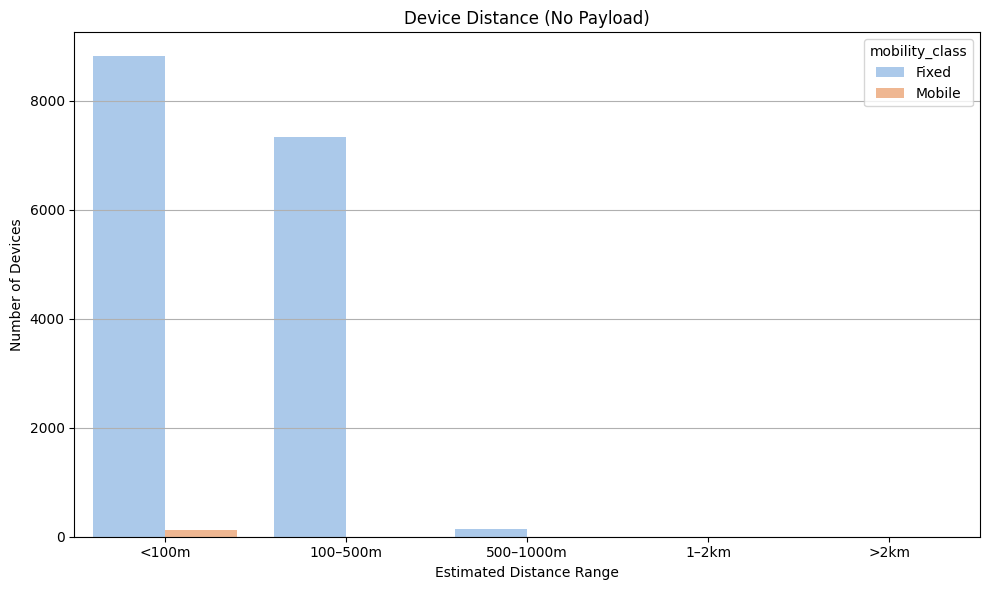

In [41]:
# Calculating estimated distance
device_none_summary['estimated_distance'] = 10 ** ((-device_none_summary['geometric_mean_rssi'] - 40) / 32)

# Binning distances
device_none_summary['distance_range'] = pd.cut(device_none_summary['estimated_distance'], bins=bins, labels=labels, right=False)

# Count devices per bin and mobility class
distance_counts_none = device_none_summary.groupby(['distance_range', 'mobility_class']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=distance_counts_none, x='distance_range', y='count', hue='mobility_class', palette='pastel')
plt.title('Device Distance (No Payload)')
plt.xlabel('Estimated Distance Range')
plt.ylabel('Number of Devices')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## **Clustering**

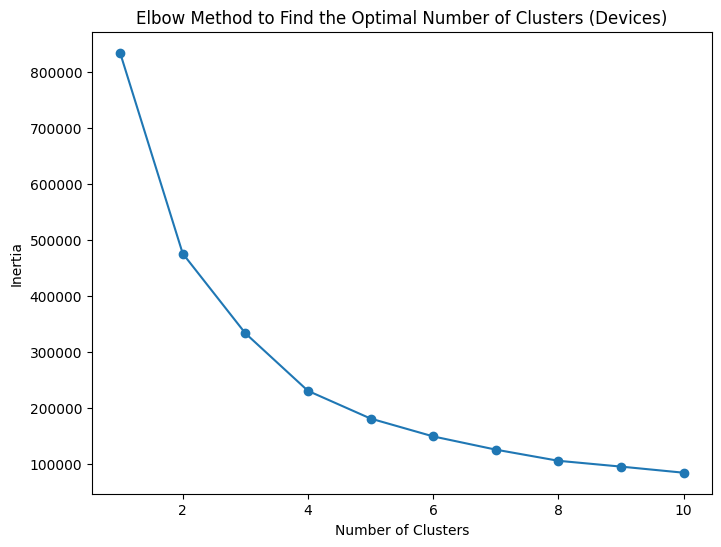


Cluster Analysis (mean of non-scaled features per device):
               rssi       lsnr       size         SF  estimated_distance
cluster                                                                 
0       -104.354379   2.418790  51.981981  11.992658          127.774016
1       -120.574515  -6.393386  60.127497   7.128035          340.457646
2       -126.691122 -12.893019  44.108519  11.912518          552.416510
3        -97.525413   4.854291  12.572095   9.976088           83.503220


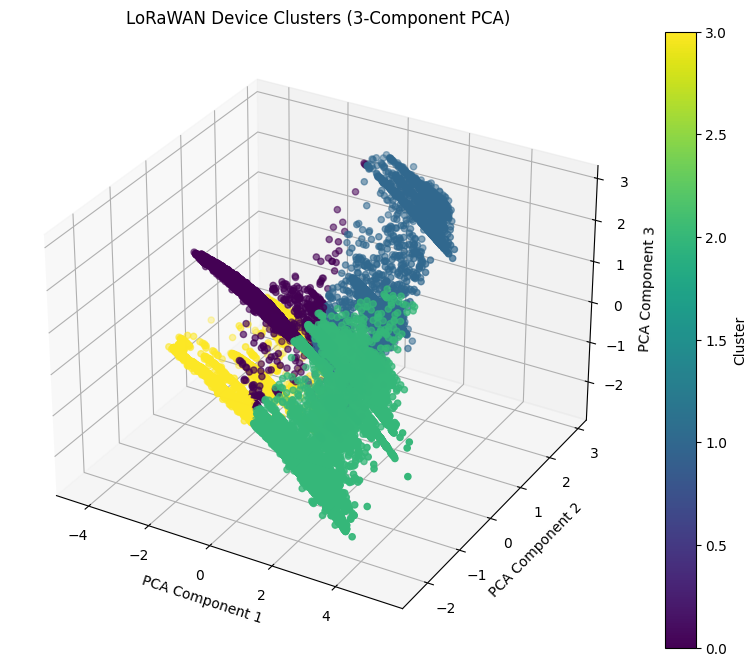

In [ ]:

# --- 1. Prepare data at the device level ---

# Ensure that the fields are numeric and handle conversion errors
numeric_cols = ['rssi', 'lsnr', 'size', 'SF', 'estimated_distance']
for col in numeric_cols:
    if col in df_uplink_cleaned.columns:
        df_uplink_cleaned[col] = pd.to_numeric(df_uplink_cleaned[col], errors='coerce')

# Remove rows with missing values in the essential columns
df_clean = df_uplink_cleaned.dropna(subset=['DevAddr'] + numeric_cols)

# Aggregate data by DevAddr
# For numeric features: compute the mean
device_features = df_clean.groupby('DevAddr').agg(
    rssi=('rssi', 'mean'),
    lsnr=('lsnr', 'mean'),
    size=('size', 'mean'),
    SF=('SF', 'mean'),
    estimated_distance=('estimated_distance', 'mean')
).reset_index()

# --- 2. Prepare features for clustering ---

# Select the features to use for clustering (aggregated ones)
features_for_clustering = ['rssi', 'lsnr', 'size', 'SF', 'estimated_distance']
X_device = device_features[features_for_clustering].copy()

# Drop any remaining missing values
X_device.dropna(inplace=True)

# Get the list of features for scaling
encoded_features = [col for col in X_device.columns]

# Scale the data
scaler = StandardScaler()
X_device_scaled = scaler.fit_transform(X_device)

# --- 3. Choose the number of clusters (elbow method) ---
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_device_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method to Find the Optimal Number of Clusters (Devices)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# --- 4. Train the K-Means model with the chosen number of clusters ---
# Replace this value with the optimal number of clusters you identified from the elbow plot
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Assign clusters to devices
device_features['cluster'] = kmeans.fit_predict(X_device_scaled)

# --- 5. Cluster analysis (mean of features per cluster) ---
cluster_analysis = device_features.groupby('cluster')[features_for_clustering].mean()
print("\nCluster Analysis (mean of non-scaled features per device):")
print(cluster_analysis)

# --- 6. Visualize clusters (dimensionality reduction for visualization) ---
if X_device_scaled.shape[1] > 3:
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_device_scaled)
    df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
    df_pca['cluster'] = device_features['cluster']

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=df_pca['cluster'], cmap='viridis')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('LoRaWAN Device Clusters (3-Component PCA)')
    fig.colorbar(scatter, label='Cluster')
    plt.show()
elif X_device_scaled.shape[1] == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_device_scaled[:, 0], y=X_device_scaled[:, 1], hue=device_features['cluster'], palette='viridis')
    plt.title('LoRaWAN Device Clusters')
    plt.xlabel(f'{encoded_features[0]} (Scaled)')
    plt.ylabel(f'{encoded_features[1]} (Scaled)')
    plt.show()
elif X_device_scaled.shape[1] == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_device_scaled[:, 0], X_device_scaled[:, 1], X_device_scaled[:, 2], c=device_features['cluster'], cmap='viridis')
    ax.set_xlabel(f'{encoded_features[0]} (Scaled)')
    ax.set_ylabel(f'{encoded_features[1]} (Scaled)')
    ax.set_zlabel(f'{encoded_features[2]} (Scaled)')
    ax.set_title('LoRaWAN Device Clusters')
    fig.colorbar(scatter, label='Cluster')
    plt.show()
else:
    print("Too many dimensions for direct visualization without dimensionality reduction.")

In [43]:
# Make sure you have already performed PCA with n_components=3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_device_scaled)

# Create a DataFrame to show the loadings (component coefficients)
features = features_for_clustering  # list of your features: ['rssi', 'lsnr', ...]
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=features)

print("\nPCA Loadings (Component Composition):")
print(loadings)


PCA Loadings (Component Composition):
                         PC1       PC2       PC3
rssi               -0.562049 -0.004739  0.100000
lsnr               -0.548302  0.155194  0.126626
size                0.278650  0.370957  0.881397
SF                 -0.099679 -0.892988  0.420113
estimated_distance  0.543952 -0.202130 -0.143562


In [44]:
# Compute number of devices per cluster

cluster_counts = device_features['cluster'].value_counts().sort_index()

print("\nNumber of devices per cluster:")
print(cluster_counts)


Number of devices per cluster:
cluster
0    52511
1    41132
2    41769
3    31571
Name: count, dtype: int64


In [45]:
# 1. Count the number of messages for each device
messages_per_device = df_uplink_cleaned['DevAddr'].value_counts().reset_index()
messages_per_device.columns = ['DevAddr', 'number_of_messages']

# 2. Merge this count with the clustered devices DataFrame
device_features_with_messages = pd.merge(device_features, messages_per_device, on='DevAddr', how='left')

# 3. Calculate the average number of messages per cluster
average_messages_per_cluster = device_features_with_messages.groupby('cluster')['number_of_messages'].mean()

# Print the result
print("\nAverage number of messages per cluster (based on devices):")
print(average_messages_per_cluster)



Average number of messages per cluster (based on devices):
cluster
0      1.223020
1     49.051736
2      8.061625
3    110.144405
Name: number_of_messages, dtype: float64


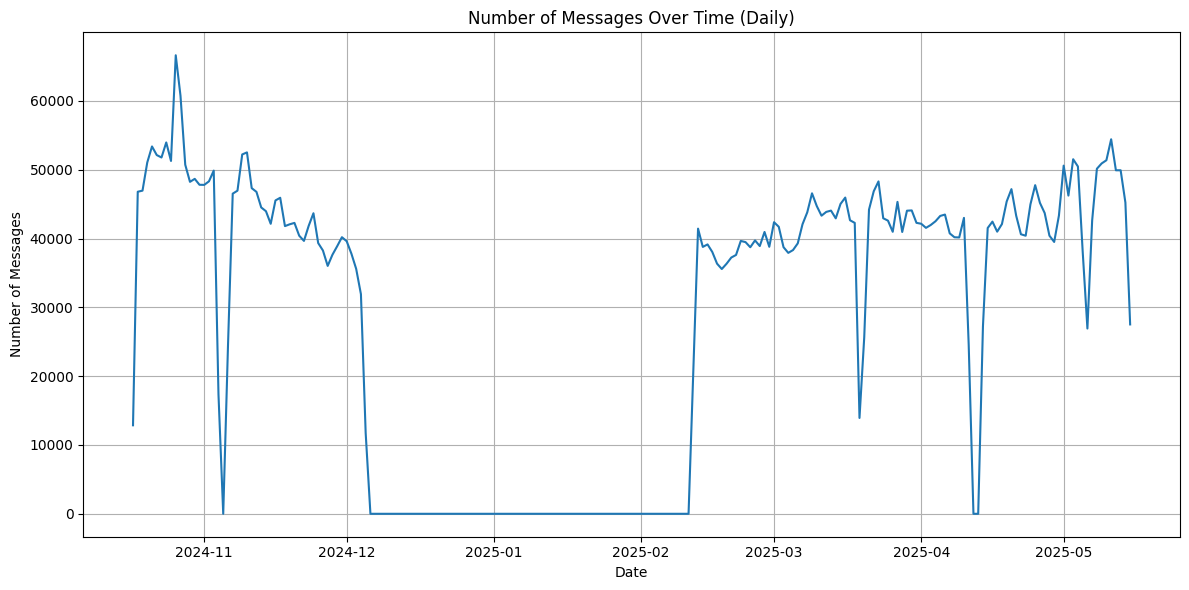

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\2990718087.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will

Text(0.5, 0, 'Weekday')

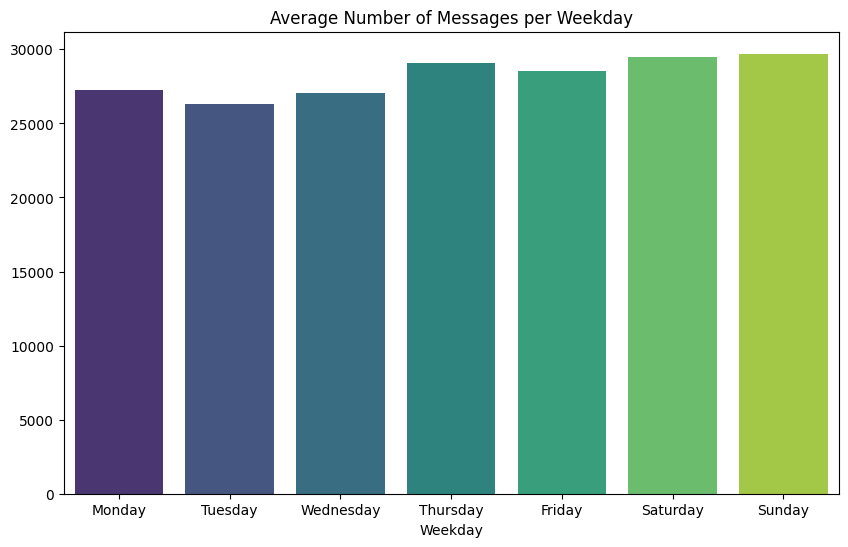

In [ ]:

# Convert the 'timestamp' column to datetime objects if it's not already
df_uplink_cleaned['timestamp'] = pd.to_datetime(df_uplink_cleaned['timestamp'])

# Set the timestamp as the index to facilitate grouping
df_uplink_cleaned.set_index('timestamp', inplace=True)

# Group by time intervals (e.g., by hour, by day) and count the messages
messages_per_interval = df_uplink_cleaned.resample('D').size()

# 1. Line plot of the number of messages per time interval
plt.figure(figsize=(12, 6))
plt.plot(messages_per_interval.index, messages_per_interval.values)
plt.title('Number of Messages Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.tight_layout()
plt.show()

# Reset the index if needed for the next plot
df_uplink_cleaned.reset_index(inplace=True)

# 2. Bar chart of the average number of messages per weekday

# Extract the weekday (0=Monday, 6=Sunday)
df_uplink_cleaned['weekday'] = df_uplink_cleaned['timestamp'].dt.dayofweek

# Group by weekday and count the messages
messages_per_weekday = df_uplink_cleaned['weekday'].value_counts().sort_index()

# Calculate the total number of weeks covered by the data (approximate)
number_of_weeks = (df_uplink_cleaned['timestamp'].max() - df_uplink_cleaned['timestamp'].min()).days / 7

# Calculate the average number of messages per weekday
average_messages_per_day = messages_per_weekday / number_of_weeks

# Translate day numbers into names
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_messages_per_day.index = days

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=average_messages_per_day.index, y=average_messages_per_day.values, palette='viridis')
plt.title('Average Number of Messages per Weekday')
plt.xlabel('Weekday')


C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\2498045745.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will

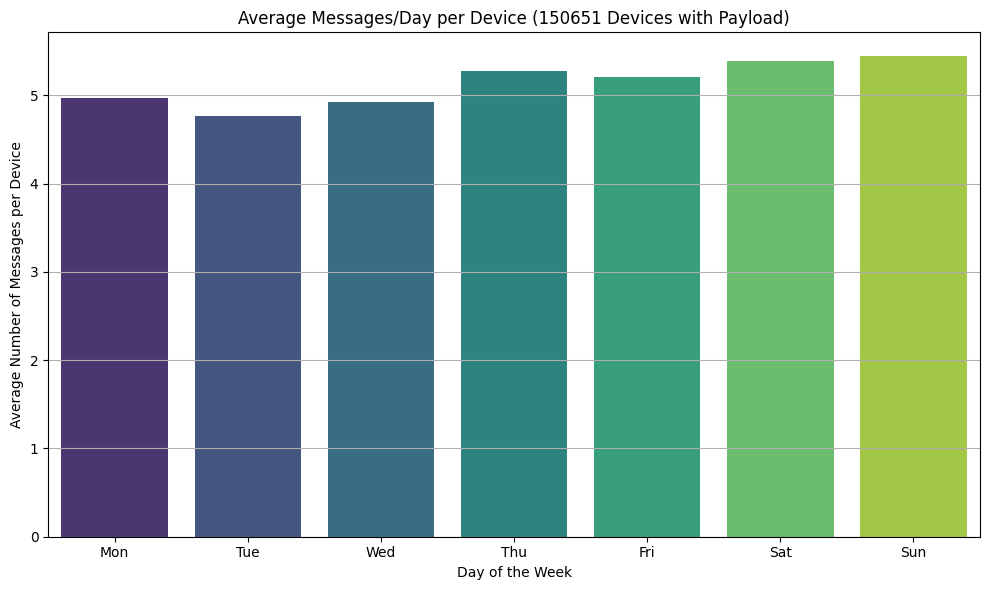

C:\Users\nephr\AppData\Local\Temp\ipykernel_2608\2498045745.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will

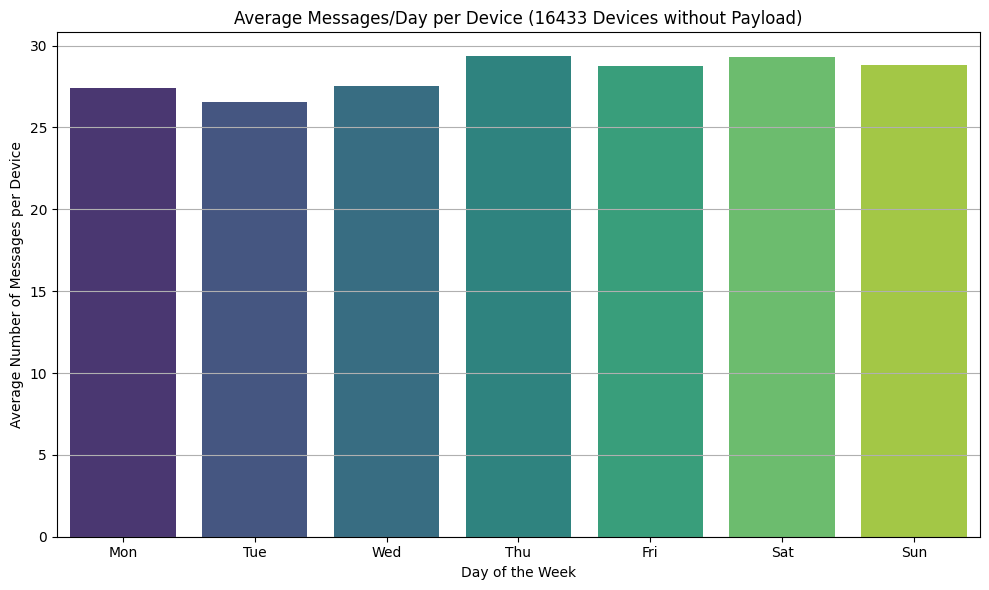

In [ ]:

# Extract the weekday
df_uplink_cleaned['weekday'] = df_uplink_cleaned['timestamp'].dt.dayofweek
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_uplink_cleaned['day_name'] = df_uplink_cleaned['weekday'].map(day_map)

# Identify devices with and without payload
devices_with_payload = set(df_uplink_cleaned[df_uplink_cleaned['FRMPayload'].notnull()]['DevAddr'].dropna().unique())
devices_without_payload = set(df_uplink_cleaned[df_uplink_cleaned['FRMPayload'].isnull()]['DevAddr'].dropna().unique())

# Function to calculate and plot the average number of messages per day for a set of devices
def plot_average_message_frequency_by_day(device_set, has_payload):
    df_subset = df_uplink_cleaned[df_uplink_cleaned['DevAddr'].isin(device_set)].copy()
    if df_subset.empty:
        print(f"No data available for devices {'with' if has_payload else 'without'} payload.")
        return

    # Count messages per device and per weekday
    count_per_device_day = df_subset.groupby(['DevAddr', 'day_name']).size().unstack(fill_value=0)

    # Calculate the average number of messages per weekday (average across devices)
    average_per_day = count_per_device_day.mean(axis=0).reindex(day_map.values()).fillna(0)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=average_per_day.index, y=average_per_day.values, palette='viridis')
    plt.title(f'Average Messages/Day per Device ({len(device_set)} Devices {"with" if has_payload else "without"} Payload)')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Number of Messages per Device')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Calculate and plot for devices with payload
plot_average_message_frequency_by_day(devices_with_payload, True)

# Calculate and plot for devices without payload
plot_average_message_frequency_by_day(devices_without_payload, False)


# **4. Downlink Analyses**

## **Valid Payloads Percentage and Unique Devices**

We immediately observed that the number of downlink messages is significantly lower than that of uplink messages, and their transmission is far more sporadic, even if the range of dates almost corresponds with the uplink. As expected, unlike uplink messages, all downlink packets contain a payload. In fact, there are no empty payloads in the downlink dataset.




In [50]:
# Counting number of Invalid Packets
num_none = df_downlink_cleaned['FRMPayload'].isna().sum()

print(f"Number of Packets without payload: {num_none}")

Number of Packets without payload: 0


In [51]:
# Count the number of unique DevAddr
unique_devaddr_count = df_downlink_cleaned['DevAddr'].nunique()
print(f"Number of unique DevAddr: {unique_devaddr_count}")


Number of unique DevAddr: 208


The results show that in the dataset there are only $208$ distinct devices. This confirms that only a small fraction of the devices in the uplink dataset actually received downlink messages, while the vast majority were limited to sending data without receiving any.

In [52]:
# Get the range of timestamps
start_date = df_downlink_cleaned['timestamp'].min()
end_date = df_downlink_cleaned['timestamp'].max()

start_date, end_date

('2024-10-17 10:53:30', '2025-05-14 20:55:18')

Given the low volume of downlink traffic, we can also reasonably exclude the possibility that these devices are  Class B. Class B devices require regular beacon transmissions to remain synchronized with the network, and the absence of frequent downlink messages makes this scenario unlikely.

Regarding the frequencies used for downlink transmissions, we found no anomalies. They fall within the standard LoRaWAN frequency range, specifically between 867.1 MHz and 869.5 MHz.

In [53]:

# Calculate min and max frequency
min_freq_dl = df_downlink_cleaned['freq'].min()
max_freq_dl = df_downlink_cleaned['freq'].max()

min_freq_dl, max_freq_dl

(867.1, 869.525)

## **Spreading Factor and MType Analyses**

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When gr

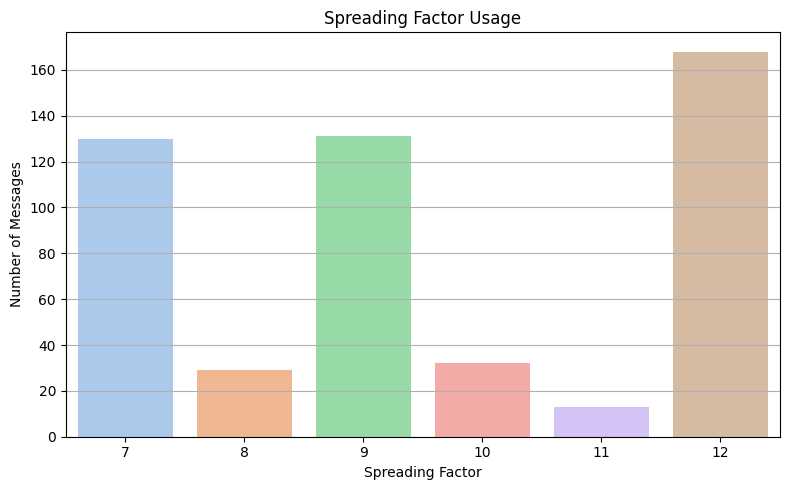

In [54]:

# Counting SF values to plot the distribution
sf_counts_dl = df_downlink_cleaned['SF'].value_counts().sort_index().reset_index()
sf_counts_dl.columns = ['SF', 'Count']

# Plotting distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=sf_counts_dl, x='SF', y='Count', hue='SF', palette='pastel', legend=False)
plt.title('Spreading Factor Usage')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Messages')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

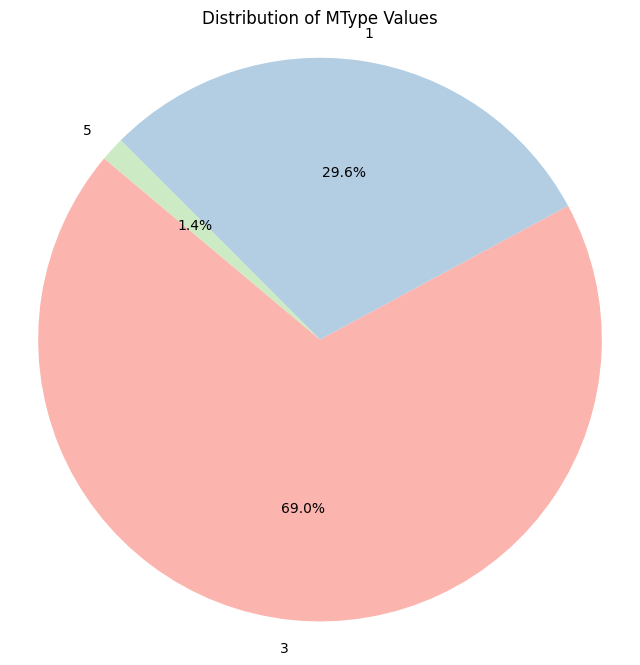

In [55]:
# Count occurrences of each MType value
mtype_counts = df_downlink_cleaned['MType'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(mtype_counts, labels=mtype_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Distribution of MType Values")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

## **Temporal Analyses**

Here we observe the distribution of downlink messages over time.

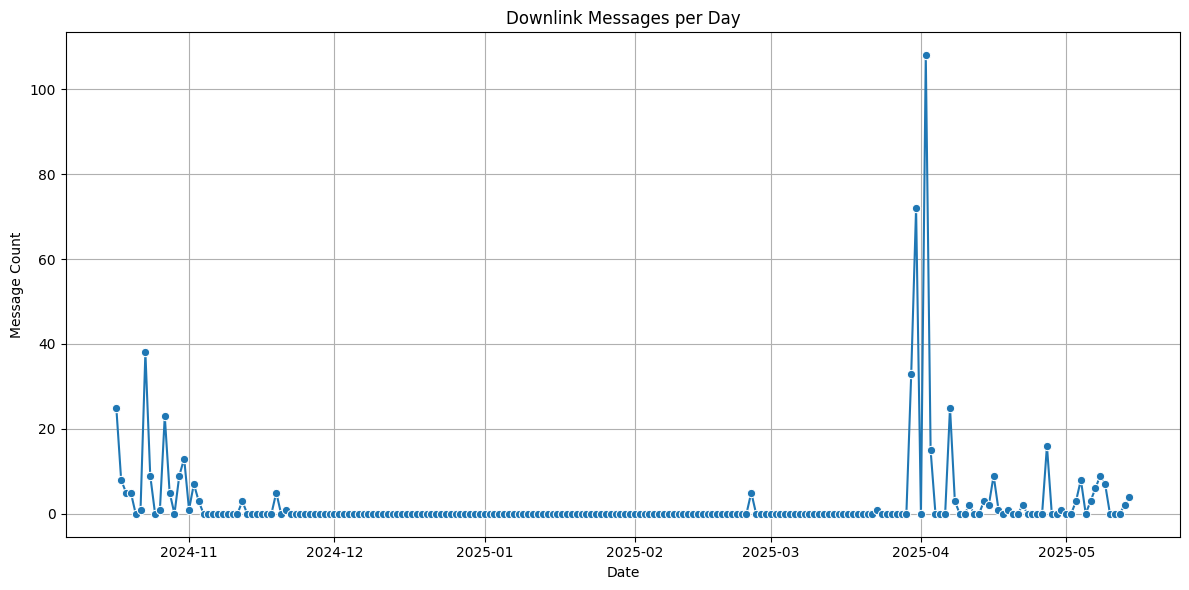

In [56]:

# Converting to datetime since it wasn't in format
df_downlink_cleaned['timestamp'] = pd.to_datetime(df_downlink_cleaned['timestamp'])

# Resample to daily counts on x-axis
daily_counts = df_downlink_cleaned.resample('D', on='timestamp').size()

# Plot temporal trend of messages
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker='o')
plt.title("Downlink Messages per Day")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Similar to the uplink dataset, there is a noticeable gap in data during the months of January and February, likely due to incomplete logging or inactivity. Aside from that, the traffic remains generally low, with only occasional spikes, most notably a peak at the beginning of April 2025. \

Regarding the size over time of those packets, on the other hand:

In [ ]:
df_downlink_cleaned['date'] = df_downlink_cleaned['timestamp'].str.slice(0, 10)
df_uplink_cleaned['date'] = df_uplink_cleaned['timestamp'].str.slice(0, 10)

# Compute daily average size
downlink_avg_size = df_downlink_cleaned.groupby('date')['size'].mean().reset_index(name='Downlink Avg Size')
uplink_avg_size = df_uplink_cleaned.groupby('date')['size'].mean().reset_index(name='Uplink Avg Size')

# Merge
avg_size_comparison = pd.merge(downlink_avg_size, uplink_avg_size, on='date', how='outer').sort_values('date')

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=avg_size_comparison, x='date', y='Downlink Avg Size', label='Downlink', s=50, color='orange', marker='D')
sns.lineplot(data=avg_size_comparison, x='date', y='Uplink Avg Size', label='Uplink', marker='s')
plt.title('Average Message Size per Day')
plt.xlabel('Date')
plt.ylabel('Average Size')

# Format x-axis to show only the first day of each month
xticks = [d for d in avg_size_comparison['date'] if d.endswith('-01')]
plt.xticks(ticks=xticks, labels=xticks, rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Then, since we want to estimate the device class, we analyzed all downlink messages with MType = 3 or 5 (Unconfirmed and Confirmed Data Down, respectively). For each of these messages, we checked whether there was a corresponding uplink message from the same device within a 3-second time window. Since Class A devices can only receive downlink messages shortly after sending an uplink, if there is at least one message for that device that doesn't satisfy this condition, then we can be sure that, that device is not a class A.

In [ ]:
# Filter downlink DevAddrs with 10 or fewer messages
filtered_devaddrs = df_downlink['DevAddr'].value_counts()
eligible_devaddrs = filtered_devaddrs[filtered_devaddrs <= 10].index.tolist()

# Create a copy to store the result per DevAddr
devaddr_check_results_limited = []

# Check for each of the first 10 eligible DevAddr
for devaddr in eligible_devaddrs:
    # Get downlink messages for this DevAddr
    dl_messages = df_downlink[df_downlink['DevAddr'] == devaddr]

    # Get uplink messages for this DevAddr
    ul_messages = df_uplink[df_uplink['DevAddr'] == devaddr]

    # Skip if no uplink messages at all
    if ul_messages.empty:
        devaddr_check_results_limited.append({'DevAddr': devaddr, 'UplinkNearbyFound': False})
        continue

    # Convert timestamps to datetime for accurate time comparison
    dl_times = pd.to_datetime(dl_messages['timestamp'])
    ul_times = pd.to_datetime(ul_messages['timestamp'])

    # Check if any downlink has an uplink within the past 5 seconds
    match_found = False
    for dl_time in dl_times:
        if any((dl_time - ul_times).dt.total_seconds().between(0, 5)):
            match_found = True
            break

    devaddr_check_results_limited.append({'DevAddr': devaddr, 'UplinkNearbyFound': match_found})

# Convert results to DataFrame
devaddr_uplink_match_limited_df = pd.DataFrame(devaddr_check_results_limited)

devaddr_uplink_match_limited_df

,DevAddr,UplinkNearbyFound
0,260bbabb,True
1,260bdbcb,True
2,260b554a,True
3,270340b6,True
4,260ba983,True
...,...,...
195,c0ba3c8e,False
196,899d75e8,False
197,3edd98cb,False
198,d81bf1bc,False


This proves that some of the devices are class A and some are class C



# **5. Case Study: Mixed Payload Devices**

Lastly, we took a closer look at the unusual case of mixed payload devices—devices that transmitted both packets with and without payloads. We observed that these devices exhibited an abnormally high number of messages compared to most other devices. Upon further inspection, we found that all of their transmissions appeared in duplicated pairs: one packet containing a payload and one without. Additionally, all of these messages were identified as join requests (MType = 0) or values reserved for future use (MType = 6 and 7), suggesting continuous and repeated network access attempts:

In [ ]:
# Filter original df_uplink for only the DevAddr in mixed_payload_devaddr
filtered_dataset = df_uplink_cleaned[df_uplink_cleaned['DevAddr'].isin(devices_with_both_set)].copy()

# Group and flag if all MType == 0 for each DevAddr
filtered_dataset['all_mtype_0'] = filtered_dataset.groupby('DevAddr')['MType'].transform(lambda x: (x == 0).all())


summary_df = filtered_dataset.groupby('DevAddr')['MType'].apply(lambda x: (x == 0).all()).reset_index()
summary_df.columns = ['DevAddr', 'all_mtypes_0']

summary_df

,DevAddr,all_mtypes_0
0,00000355,False
1,00000356,False
2,00000358,False
3,0000035f,False
4,00000360,False
...,...,...
96,c90c9220,True
97,d60b8b00,False
98,f8051a37,True
99,fe0b28ac,True


In [ ]:

# Get DevAddr values from summary_df where all_mtypes_0 is False
non_mtype0_devaddrs = summary_df[summary_df['all_mtypes_0'] == False]['DevAddr']

# Filter original dataset for those DevAddr
relevant_rows = df_uplink_cleaned[df_uplink_cleaned['DevAddr'].isin(non_mtype0_devaddrs)]

# Get unique MType values per DevAddr
mtype_per_devaddr = relevant_rows.groupby('DevAddr')['MType'].unique().reset_index()
mtype_per_devaddr.columns = ['DevAddr', 'Unique_MTypes']

mtype_per_devaddr

,DevAddr,Unique_MTypes
0,00000355,[7.0]
1,00000356,[7.0]
2,00000358,[7.0]
3,0000035f,[7.0]
4,00000360,[7.0]
5,0000036e,[7.0]
6,00000374,[7.0]
7,00000384,[7.0]
8,000013b6,[7.0]
9,000013bc,[7.0]


From this last check we verifies that all MTypes for the messages of these kind of devices are either 0, 6 or 7.

In [ ]:
# Filter the downlink dataset for MType = 1
mtype1_downlinks = df_downlink_cleaned[df_downlink_cleaned['MType'] == 1]

# Extract the unique DevAddr values from these messages
devaddr_mtype1 = mtype1_downlinks['DevAddr'].unique()

# Convert to a list if needed
devaddr_mtype1_list = devaddr_mtype1.tolist()

# Display the list
print(devaddr_mtype1_list)


['352d421f', '7fbf9f82', 'a7d5bbb0', 'c3cfa519', '2fea59ca', '7f8af58a', '03e4cd3d', 'b5ca961c', 'e254be03', 'b08561d1', '8a6a5cdd', 'ffa20418', '26e84515', 'c609f166', '6234bca9', '0b7300d2', 'b73ccc7e', '64dd8664', '51f6f1b5', '27f5f447', 'c006101f', 'b3280a84', '76ec3148', 'e4bbbc3e', '886f2ab0', '1f8f1d4b', '67338b4d', '45428af4', '0397df91', 'bca4ec79', '91f650b5', 'ba381af5', '1957a4bb', '6a9bc808', '834fae27', '85a4df00', '80079e37', '7210c8ad', 'd3b07bdf', '09901bd1', 'bdb7bb0a', 'a10fcbfb', '583003e6', '68ac0adb', 'dc58acac', '30733146', '955b3b1d', '1700da11', 'c15826c5', '59f607f8', 'cd0ac371', '56d35455', '1670a2b5', '42006c73', '116a8242', '730480e2', 'c0ba3c8e', '899d75e8', '3edd98cb', 'd81bf1bc', 'fbf3349d', '5ad52374', 'd006d27a', 'acec7238', 'b53e33d7', '1013403e', '955f499b', 'c50fd116', 'fa104397', 'bda32958', '285efd63', 'd2f98eae', '65b02e24', 'acc7e8cb', '267d1185', '0cb41b77', '469b7343', 'ab7ca114', 'e9b99014', '55060b24', 'ea323b6b', '5c8b9469', '921765df', 'fc

Inspecting the Downlink packets with MType = 1, we notice that those packets requests have never been accepted, therefore they are continuously spamming request and increasing traffic.

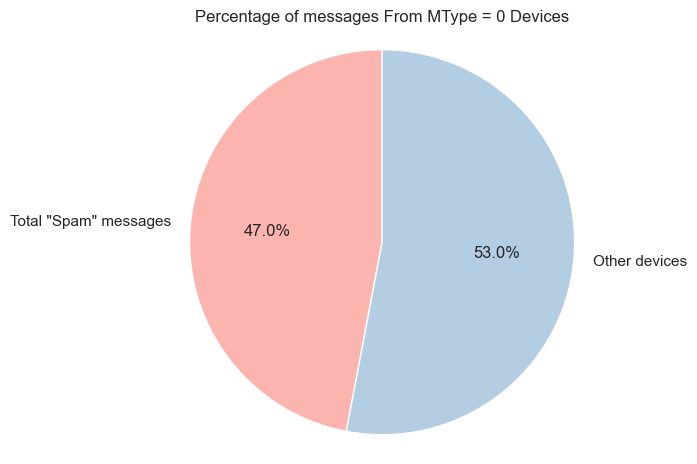

In [ ]:
# Filtro i messaggi inviati solo dai dispositivi in devices_with_both_set
messages_from_both = df_uplink_cleaned[df_uplink_cleaned['DevAddr'].isin(devices_with_both_set)]

# Conteggio
count_from_both = len(messages_from_both)
total_count = len(df_uplink_cleaned)
other_count = total_count - count_from_both

# Dati per il grafico a torta
labels = ['Total "Spam" messages', 'Other devices']
sizes = [count_from_both, other_count]

# Plot a torta
plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Percentage of messages From MType = 0 Devices')
plt.axis('equal')
plt.tight_layout()
plt.show()

# **Conclusions**

We conducted an in-depth analysis of both uplink and downlink packets handled by the gateway. The key conclusions are as follows:
1. Most of the devices transmitting to the gateway appear to be LoRaWAN Class A and C devices. They are likely fixed in position and show a relatively consistent signal strength over time.
2. The frequent use of Spreding Factor of 7 suggests a stable connection, however, the signal quality is likely affected by the dense urban environment, which causes some degradation, as seen in the lsnr and rssi distribution.
3. While the majority of devices transmit standard LoRa data, a small subset of devices generates a disproportionately large number of non-LoRa-standard packets. These packets are unusable and essentially flood the gateway. These devices are also estimated to be stationary and located within 200 meters of the gateway, indicating local interference.
4. In addition to those sending unusable data, we identified a group of devices that repeatedly send the same Join Request to the gateway—often in duplicate. These messages increase traffic load unnecessarily and contribute further to the volume of unvaluable data.
5. The majority of messages are application-layer uplinks, with only a small fraction serving other purposes. Most devices only transmit data and do not receive any downlink, reinforcing their classification as typical Class A devices.
6. Both uplink and downlink packets follow standard LoRaWAN configurations in terms of frequency and bandwidth, with no anomalies detected in these parameters.
7. Finally, there is no significant temporal trend observed in the transmission patterns. However, we observed there is a temporal gap in both the uplink and downlink dataset of the duration of approximately two months, from december 2024 to february 2025, where most likely the gateway was shut off or data collection was not performed.